This notebook will demonstrate the ideas that we have learned in a multiclass classification setting.

In [1]:
DEV = True

#### Create a multiclass dataset.

In [2]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # method to create blobs
from sklearn.model_selection import train_test_split

import helper_functions

Set hyperparameters.

In [3]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

Create multiclass data.

In [4]:
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5, # std devs of cluster points around their centers
                            random_state = RANDOM_SEED)

# convert ndarrays into torch tensors, float64 of numpy to float32 of torch
X_blob = torch.from_numpy(X_blob).type(torch.float32)

# VVI: this notebook uses CrossEntropy loss that will expect a LongTensor in the target field.
# y = torch.from_numpy(y).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

In [5]:
X_blob[0:5], y_blob[0:5]

(tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661],
         [ 3.9508,  0.6984],
         [ 4.2505, -0.2815]]),
 tensor([3, 2, 2, 1, 1]))

Visualize the data.

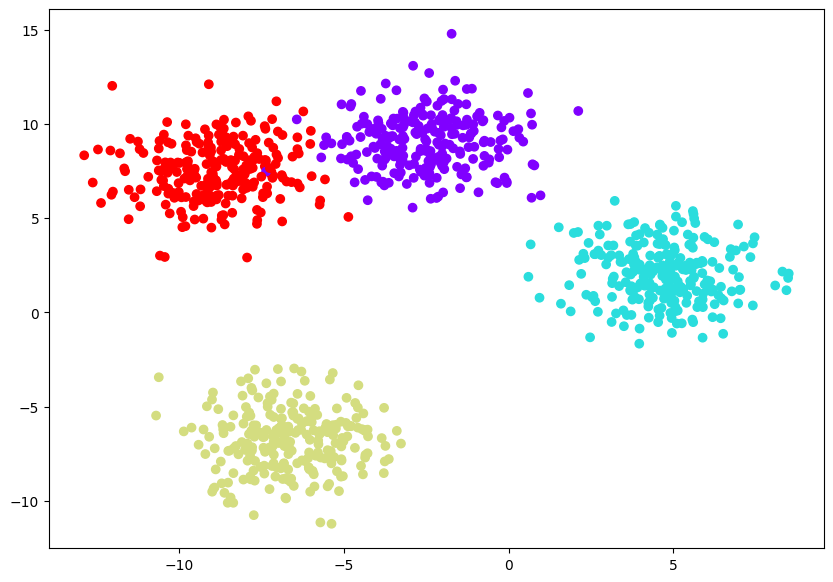

In [6]:
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.rainbow)

Train-Test split.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_blob,
                                                    y_blob,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

In [8]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

#### Build a classifier.

Build a multiclass classification model.

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class Multiclass_Classifier(torch.nn.Module):

    def __init__(self):
        """
        Initializes a multiclass classification model.
        """
        super().__init__()
        self.linear1 = torch.nn.Linear(in_features=NUM_FEATURES, out_features=8)
        #self.leaky_relu1 = torch.nn.LeakyReLU()
        self.linear2 = torch.nn.Linear(in_features=8, out_features=16)
        #self.leaky_relu2 = torch.nn.LeakyReLU()
        self.linear3 = torch.nn.Linear(in_features=16, out_features=32)
        #self.leaky_relu3 = torch.nn.LeakyReLU()
        self.linear4 = torch.nn.Linear(in_features=32, out_features=16)
        #self.leaky_relu4 = torch.nn.LeakyReLU()
        self.linear5 = torch.nn.Linear(in_features=16, out_features=8)
        #self.leaky_relu5 = torch.nn.LeakyReLU()
        self.linear6 = torch.nn.Linear(in_features=8, out_features=NUM_CLASSES)

    def forward(self, x: torch.Tensor) -> torch.tensor:
        """
        Returns the output of forward propagation of the model.
        """
        # notice that hidden non-linear layers are not needed since we will softmax at the end
        #return self.linear6(self.leaky_relu5(self.linear5(self.leaky_relu4(self.linear4(self.leaky_relu3(self.linear3(self.leaky_relu2(self.linear2(self.leaky_relu1(self.linear1(x)))))))))))
        return self.linear6(self.linear5(self.linear4(self.linear3(self.linear2(self.linear1(x))))))

In [11]:
demo_classifier = Multiclass_Classifier()
demo_classifier

Multiclass_Classifier(
  (linear1): Linear(in_features=2, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=16, bias=True)
  (linear5): Linear(in_features=16, out_features=8, bias=True)
  (linear6): Linear(in_features=8, out_features=4, bias=True)
)

Check for correctness of the shapes before training.<br>
Logits --> Predictions Probabilities --> Prediction Labels using argmax()

In [12]:
with torch.inference_mode():
    _y_pred_logits = demo_classifier(X_train)
    print("\n_y_pred_logits shape: ",_y_pred_logits.shape)
    print("\n_y_pred_logits: ",_y_pred_logits[0:3,:])
    _y_pred_probabilities =  torch.softmax(demo_classifier(X_train), dim = 1)  
    print("\n_y_pred_probabilities: ",_y_pred_probabilities[0:3,:])
    sum_of_prob_first_sample = sum(_y_pred_probabilities[0,:])
    print("\nSum of probabilities for the first sample: ",sum_of_prob_first_sample)
    _y_preds = torch.argmax(_y_pred_probabilities[0:3,:], dim = 1)
    print("\n_y_preds: ", _y_preds)


_y_pred_logits shape:  torch.Size([800, 4])

_y_pred_logits:  tensor([[ 0.4790,  0.3979, -0.0175,  0.0218],
        [ 0.6641,  0.4874, -0.0939,  0.0432],
        [-0.7562, -0.0698, -0.0941,  0.1875]])

_y_pred_probabilities:  tensor([[0.3161, 0.2914, 0.1924, 0.2001],
        [0.3516, 0.2947, 0.1648, 0.1890],
        [0.1334, 0.2651, 0.2587, 0.3428]])

Sum of probabilities for the first sample:  tensor(1.0000)

_y_preds:  tensor([0, 0, 3])


#### Training Loop


In [13]:
classifier = Multiclass_Classifier()
classifier = classifier.to(device=device)
classifier

Multiclass_Classifier(
  (linear1): Linear(in_features=2, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=16, bias=True)
  (linear5): Linear(in_features=16, out_features=8, bias=True)
  (linear6): Linear(in_features=8, out_features=4, bias=True)
)

Create a loss function, an optimizer, and a learning rate scheduler.

In [14]:

loss_func = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params= classifier.parameters(), lr = 0.1)

from torch.optim.lr_scheduler import CyclicLR

scheduler = CyclicLR(optimizer, 
                     base_lr = 0.1, # Initial learning rate which is the lower boundary in the cycle for each parameter group
                     max_lr = 1e-2, # Upper learning rate boundaries in the cycle for each parameter group
                     step_size_up = 3, # Number of training iterations in the increasing half of a cycle
                     mode = "triangular")

In [15]:
classifier(X_train.to(device))[:5]

tensor([[ 0.1553, -0.4687,  0.0884,  0.3064],
        [ 0.2233, -0.9097, -0.2884,  0.5734],
        [-0.0668, -0.2641, -0.0945,  0.2990],
        [ 0.0082, -0.4000, -0.1091,  0.3482],
        [ 0.1873, -0.8290, -0.2637,  0.5389]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [16]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#classifier = Multiclass_Classifier(2,4,8).to(device)

X_train = X_train.to(device = device)
# the network output, y_preds, itself will be a 1D tensor after passin through torch.argmax()
# torch.nn.CrossEntropyLoss() supports only 0D or 1D tensor for prediction tensor and target tensor
# hence, y_train and y_test need not be unsqueezed here unlike for binary classification
# y_train = torch.unsqueeze(y_train, dim=1)
y_train = y_train.to(device=device)
X_test = X_test.to(device = device)
# y_train and y_test need not be unsqueezed here unlike for binary classification
# y_test = torch.unsqueeze(y_test, dim = 1) # convert to same dimension as the network output
y_test = y_test.to(device=device)


epochs = 100

epoch_ctr = []
training_loss_list, test_loss_list = [], []
training_acc_list, test_acc_list = [], []

for epoch in range(0, epochs):

    ### training
    classifier.train()

    y_pred_logits = classifier(X_train)
    y_pred_probabilities = torch.softmax(y_pred_logits, dim = 1) # softmax along dim 1 for each sample  
    y_preds = y_pred_probabilities.argmax(dim=1) # argmax along dim 1    
    #y_preds = torch.softmax(y_pred_logits, dim=1).argmax(dim=1)

    training_loss = loss_func(y_pred_logits, y_train)
        
    optimizer.zero_grad()

    # backpropagation: calculate the gradients using backpropagation for the entire dataset at once
    # hence, this is not Stochastic Gradient Descent, but rather Gradient Descent
    training_loss.backward()

    optimizer.step()

    ### evaluating

    classifier.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = classifier(X_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_func(test_logits, y_test)
      test_acc = helper_functions.accuracy_fn(y_true=y_test,
                             y_pred=test_pred)


    with torch.inference_mode():
        
        # test loss
        test_pred_logits = classifier(X_test)
        test_pred_probabilities = torch.softmax(test_pred_logits, dim = 1)# softmax along dim 1 for each sample
        test_preds = test_pred_probabilities.argmax(dim = 1)
        test_loss = loss_func(test_pred_logits, y_test)       
        training_acc= (torch.eq(y_preds, y_train).sum().item()/len(y_train)) * 100.
        test_accuracy = (torch.eq(test_preds, y_test).sum().item()/len(y_test)) * 100.


        epoch_ctr.append(epoch)
        # store both accuracy and loss info for plots
        training_loss_list.append(training_loss.to("cpu").item())
        test_loss_list.append(test_loss.to("cpu").item())
        training_acc_list.append(training_acc)
        test_acc_list.append(test_accuracy)

        # print at each 10th percentile
        if epoch % (epochs/10) == 0:
            
            print("EPOCH ", epoch, " | Training loss: ",round(training_loss.detach().item(),3)," | Test loss: ", round(test_loss.item(),3),\
            " | Training acc: ",round(training_acc,3),"% | Test acc: ", round(test_accuracy,3), "%")

    # update the lr
    scheduler.step()


EPOCH  0  | Training loss:  1.339  | Test loss:  1.203  | Training acc:  24.125 % | Test acc:  29.0 %
EPOCH  10  | Training loss:  0.546  | Test loss:  0.48  | Training acc:  72.75 % | Test acc:  75.5 %
EPOCH  20  | Training loss:  0.061  | Test loss:  0.033  | Training acc:  97.875 % | Test acc:  99.0 %
EPOCH  30  | Training loss:  0.037  | Test loss:  0.026  | Training acc:  99.0 % | Test acc:  99.0 %
EPOCH  40  | Training loss:  0.03  | Test loss:  0.01  | Training acc:  99.0 % | Test acc:  99.5 %
EPOCH  50  | Training loss:  0.025  | Test loss:  0.013  | Training acc:  99.125 % | Test acc:  99.5 %
EPOCH  60  | Training loss:  0.023  | Test loss:  0.012  | Training acc:  99.25 % | Test acc:  99.5 %
EPOCH  70  | Training loss:  0.023  | Test loss:  0.012  | Training acc:  99.375 % | Test acc:  99.5 %
EPOCH  80  | Training loss:  0.023  | Test loss:  0.012  | Training acc:  99.375 % | Test acc:  99.5 %
EPOCH  90  | Training loss:  0.022  | Test loss:  0.012  | Training acc:  99.375 % 

#### Visualize results.

Decision Boundary

In [17]:
# download helper functions
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists in the directory. Skipping the download.")
else:
    print("Downloading helper_functions.py")
    raw_url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    request = requests.get(raw_url)

    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py already exists in the directory. Skipping the download.


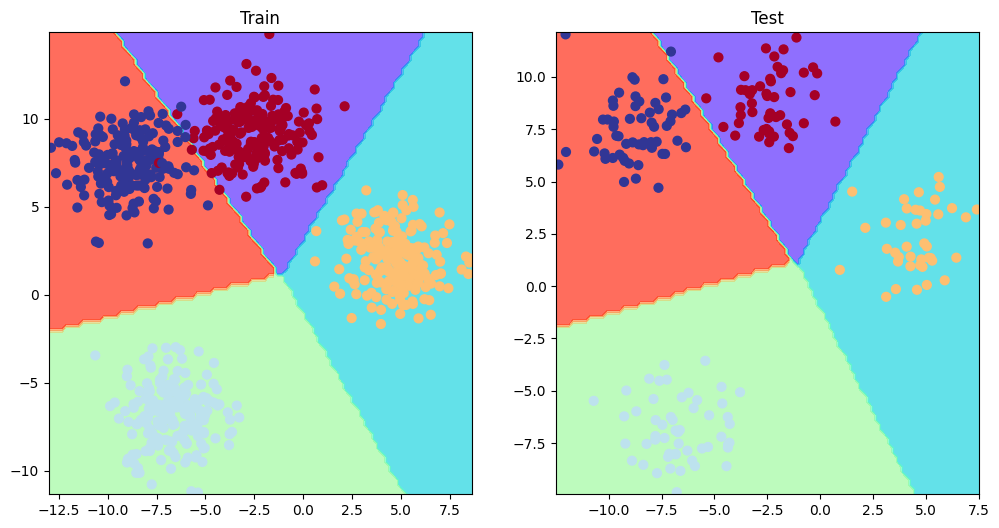

In [18]:
plt.figure(figsize=(12,6))
# 1 row in the plot, 2 columns in the plot, anything below in this slot 1
plt.subplot(1,2,1) 
plt.title("Train")
plot_decision_boundary(classifier, X_train, y_train)
# 1 row in the plot, 2 columns in the plot, anything below in this slot 2
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(classifier, X_test, y_test)

Accuracy and Loss.

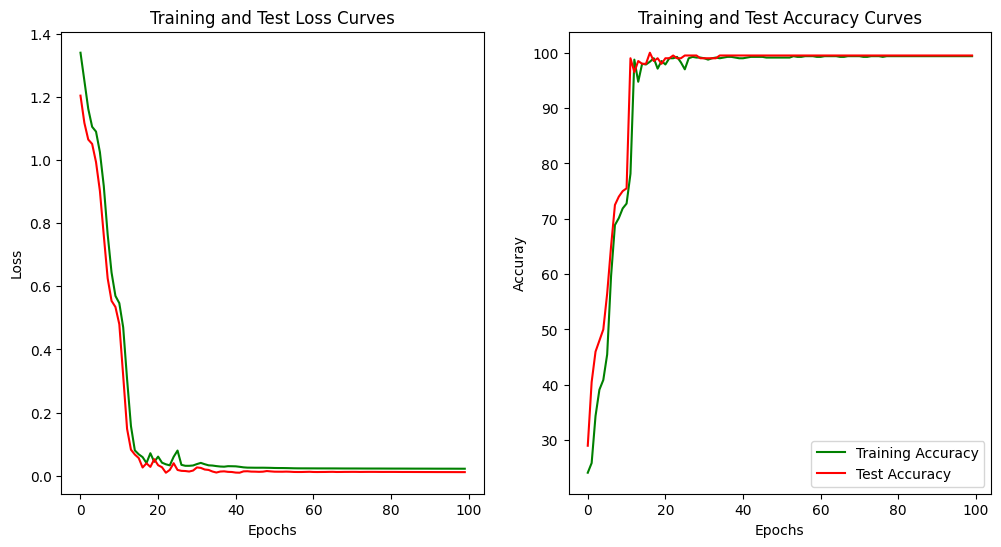

In [19]:
plt.figure(figsize=(12,6))

# subplot 1
plt.subplot(1,2,1) 
plt.title("Loss")
plt.plot(epoch_ctr, training_loss_list, "g", label = "Training Loss")
plt.plot(epoch_ctr, test_loss_list, "r", label = "Test Loss")
plt.title("Training and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# subplot 2
plt.subplot(1,2,2)
plt.title("Test")
plt.title("Accuracy")
plt.plot(epoch_ctr, training_acc_list, "g", label = "Training Accuracy")
plt.plot(epoch_ctr, test_acc_list, "r", label = "Test Accuracy")
plt.title("Training and Test Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuray")

plt.legend()
plt.show()

As seen above, several linear boundaries are formed to separate the (almost) linearly-separable classes.